## Combining ML1 ML2 and ML4 dataset after removing Batch Effect
### Experiments:
1. Z-score normalization independently on each dataset and combine dataset with stratified (label and batch).
2. Split the model 60/40 train the model and test

In [1]:
import sys
import os
import pandas as pd

sys.path.insert(0, '../')

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.base import clone
from sklearn.metrics import r2_score

from src.load_dataset import load_dataset
from src.utils import tsen_pca_viz, verify_batch_label_dist, calculate_r2_score, calculate_per_diff, per_error, find_adj_score, perform_combat_normalization
from src.load_models import select_model
from src.graph_visualization import visualization_testing_dataset
from src.config import *

In [2]:
# Load dataset
normalization    = True
standardize_type = 'min_max' if normalization else 'none'
split            = False
combat_norm      = True

ML1_X, ML1_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, split=split)
ML2_X, ML2_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, split=split)
ML4_X, ML4_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=normalization, standardize_type=standardize_type, split=split)

In [3]:
df = pd.DataFrame([ML1_X.mean(axis=0).values, ML2_X.mean(axis=0).values, ML4_X.mean(axis=0).values], columns=ML1_X.columns).round(5)
df.index= ['ML1', 'ML2', 'ML4']
df

,"univariate, area(S)",peak curvature,"univariate, V_max(S)",vcenter,"univariate, max(S)","univariate, mean(S)","univariate, std(S)","univariate, max(dS/dV)","univariate, min(dS/dV)","univariate, max(dS/dV) - min(dS/dV)","univariate, V_max(dS/dV)","univariate, V_min(dS/dV)","univariate, area(dS/dV)"
ML1,0.43397,0.36379,0.72790,0.51502,0.34075,0.43292,0.34182,0.33216,0.68507,0.32142,0.57443,0.72179,0.34077
ML2,0.38532,0.32989,0.65874,0.43553,0.30043,0.38747,0.30137,0.29186,0.73210,0.27443,0.38335,0.69674,0.30043
ML4,0.37218,0.41802,0.50867,0.47723,0.36204,0.37367,0.35164,0.37124,0.63783,0.36483,0.51187,0.60765,0.36200


In [4]:
df = pd.DataFrame([ML1_X.std(axis=0).values, ML2_X.std(axis=0).values, ML4_X.std(axis=0).values], columns=ML1_X.columns).round(5)
df.index= ['ML1', 'ML2', 'ML4']
df

,"univariate, area(S)",peak curvature,"univariate, V_max(S)",vcenter,"univariate, max(S)","univariate, mean(S)","univariate, std(S)","univariate, max(dS/dV)","univariate, min(dS/dV)","univariate, max(dS/dV) - min(dS/dV)","univariate, V_max(dS/dV)","univariate, V_min(dS/dV)","univariate, area(dS/dV)"
ML1,0.23716,0.23561,0.20377,0.29046,0.26646,0.23735,0.26847,0.27661,0.26672,0.27190,0.22071,0.16980,0.26649
ML2,0.21036,0.23259,0.19611,0.26487,0.23379,0.21030,0.23299,0.23245,0.22624,0.22978,0.16303,0.17346,0.23380
ML4,0.26369,0.29980,0.18753,0.23001,0.28488,0.26367,0.27759,0.28777,0.29404,0.29171,0.20810,0.15676,0.28488


[(0, 130), (130, 246), (246, 361)]


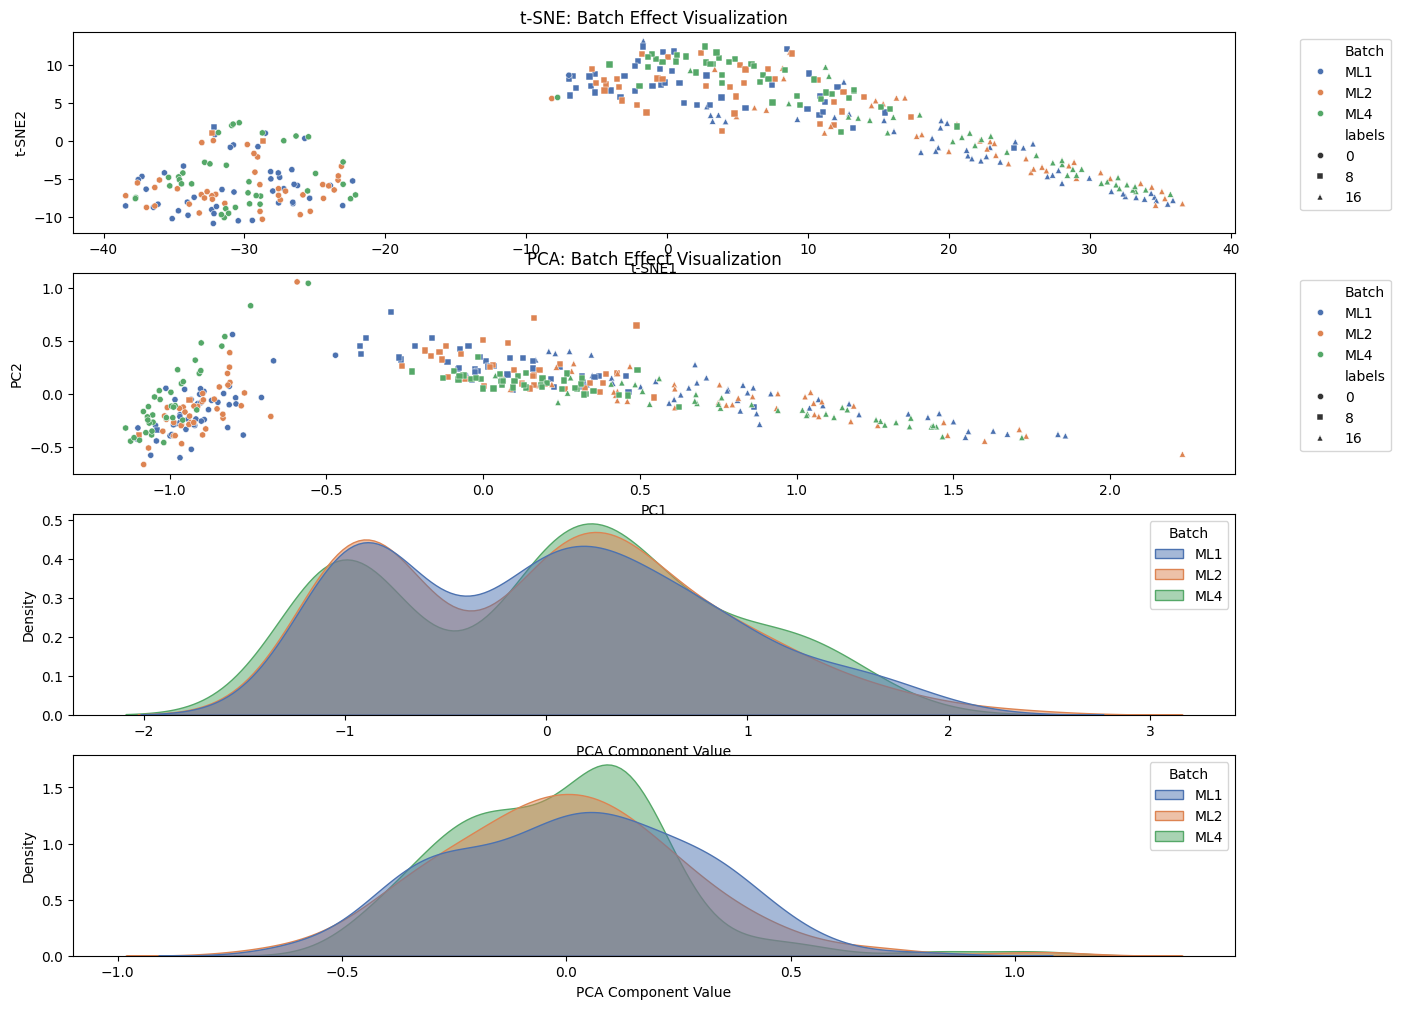

In [5]:
if combat_norm:
    (ML1_X, ML2_X, ML4_X), batch_labels = perform_combat_normalization([ML1_X, ML2_X, ML4_X], dataset_name=['ML1', 'ML2', 'ML4'])
    labels               = ML1_y.values.tolist() + ML2_y.values.tolist() + ML4_y.values.tolist()
    tsen_pca_viz([ML1_X, ML2_X, ML4_X], batch_labels, labels)

It seems the mean is nearly equal to zero and std is 1

In [6]:
# perform stratified train test split
X                = pd.concat([ML1_X, ML2_X, ML4_X], axis=0)
y                = ML1_y.values.tolist() + ML2_y.values.tolist() + ML4_y.values.tolist()
stratified_label = ML1_y.map(lambda x: f'ML1_{x}').values.tolist() + ML2_y.map(lambda x: f'ML2_{x}').values.tolist() + ML4_y.map(lambda x: f'ML4_{x}').values.tolist()

X_train, X_test, y_train_strat, y_test_strat = train_test_split(X, stratified_label, test_size=0.4, shuffle=True, random_state=20, stratify=stratified_label)
y_train, y_test = pd.Series(y_train_strat).map(lambda x: eval(x.split('_')[1])), pd.Series(y_test_strat).map(lambda x: eval(x.split('_')[1]))

## Verify training and testing distribution

In [7]:
# Verify the percentage of labels and batch
train_dist = verify_batch_label_dist(y_train_strat)
test_dist  = verify_batch_label_dist(y_test_strat)

In [8]:
# List of models
models = ['Linear', 'KNN', 'SVM', 'RF', 'GP', 'Ridge', 'Lasso', 'univariate, std(S)', 'univariate, max(dS/dV)', 'univariate, area(dS/dV)', 'univariate, area(S)', 'univariate, max(S)']

# Calcualte y_LOD
y_LOD = 0.9117010154341669 #calculate_y_LOD(X_testing, y_testing)
#print("y_LOD", y_LOD)

kf = KFold(n_splits=5)

r2_score_val,  per_diff_val  = {'Models':[], 'Scores':[]}, {'Models':[], 'Scores':[]}
r2_score_test, per_diff_test = {'Models':[], 'Scores':[]}, {'Models':[], 'Scores':[]}

for model_name in models:
    model    = select_model(model_name)

    val_r2     = calculate_r2_score(model, X_train[models_features_r2[model_name]],  y_train, kf)
    val_per    = calculate_per_diff(model, X_train[models_features_per[model_name]], y_train, kf, y_LOD)

    r2_score_val['Scores'].append(val_r2)
    per_diff_val['Scores'].append(val_per)

    model_r2  = clone(model)
    model_r2.fit(X_train[models_features_r2[model_name]], y_train)
    y_pred_r2 = model_r2.predict(X_test[models_features_r2[model_name]])

    r2_test_score = r2_score(y_test, y_pred_r2)
    adj_r2_test   = find_adj_score(len(y_pred_r2), len(models_features_r2[model_name]), r2_test_score)
    
    r2_score_test['Scores'].append((r2_test_score, adj_r2_test))

    model_per_diff = clone(model)
    model_per_diff.fit(X_train[models_features_per[model_name]], y_train)
    y_pred_per_diff = model_per_diff.predict(X_test[models_features_per[model_name]])
    
    per_diff_test['Scores'].append(per_error(y_test, y_pred_per_diff, y_LOD))

    r2_score_val['Models'].append(model_name)
    per_diff_val['Models'].append(model_name) 
    r2_score_test['Models'].append(model_name)
    per_diff_test['Models'].append(model_name)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.513e+00, tolerance: 7.411e-01
  model = cd_fast.enet_coordinate_descent(


In [9]:
savedir   = f'../results/combined_ML1_ML2_ML4/{standardize_type}_{combat_norm}'
adj_score = False

os.makedirs(savedir, exist_ok=True)

visualization_testing_dataset(r2_score_val,  f'{savedir}/r2_score_val.png',   model_name_conversion, only_one_multivariate=False, adj_score=adj_score, legends=True)
visualization_testing_dataset(per_diff_val, f'{savedir}/per_error_val.png', model_name_conversion, only_one_multivariate=False, r2_score=False, adj_score=False, legends=True)

visualization_testing_dataset(r2_score_test,  f'{savedir}/r2_score_test.png',   model_name_conversion, only_one_multivariate=False, adj_score=adj_score, legends=True)
visualization_testing_dataset(per_diff_test, f'{savedir}/per_error_test.png', model_name_conversion, only_one_multivariate=False, r2_score=False, adj_score=False, legends=True)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>